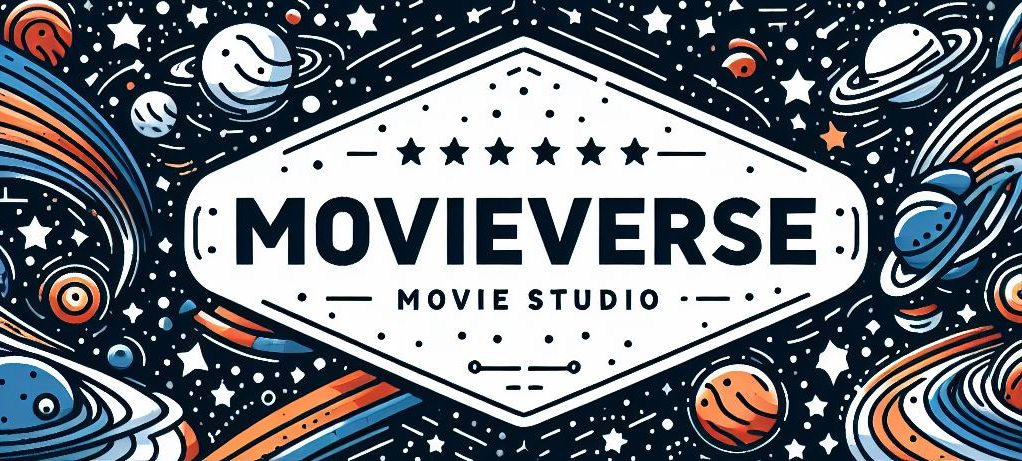

## Overview


Your company would like to start a movie studio and is asking us to recommend the best way foward. The main objective of this project is to produce three actionable recommendations for your company to take into consideration. With these recommendations your company can create their own *successful* movie studio.

This project utilizes python for exploratory data analysis and python along with SQL for interacting with the data in the databases. 


### Data Sources 

The data is sourced from various movie data websites online:
> - Box Office Mojo
    > - Format: csv 
> - IMDB
    > - Format: Database
> -  The Numbers
    > - Format: csv

We joined all the relevant data as tables into the IMDB database in the exploratory notebook for easier access and analysis. 



In [83]:
# import neeeded libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# open connection to the database
conn = sqlite3.connect('/Users/nechamaborisute/Desktop/phase-2-project/zippedData/im.db')

In [3]:
# take a look at the tables in the database
pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = "table"

""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,box_office_mojo
9,tn_movie_budgets


In [ ]:
pd.read_sql("""
SELECT *
FROM tn_movie_budgets
LIMIT 5

""", conn)

In [ ]:
pd.read_sql("""

SELECT m.genres,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                t.production_budget
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres
ORDER BY average_worldwide_gross DESC
LIMIT 5

""", conn)

In [ ]:
genre_profit = pd.read_sql("""

SELECT m.genres,
                COUNT(m.genres) AS genre_count,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                            AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres
HAVING genre_count > 10
ORDER BY average_profit_perc DESC
LIMIT 25

""", conn)

In [ ]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

# Scatter plot
sns.scatterplot(x='average_worldwide_gross', y='average_production_budget', hue='genres', markers='genres', data=genre_profit, ax=ax1)
ax1.set_xlabel('Average Worldwide Gross')
ax1.set_ylabel('Average Production Budget')
ax1.set_title('Relationship between Worldwide Gross and Production Budget by Genre')

# Bar graph
sns.barplot(x='genres', y='average_profit_perc', data=genre_profit, ax=ax2)
ax2.set_xlabel('Genres')
ax2.set_ylabel('Average Profit Percentage')
ax2.set_title('Average Profit Percentage by Genre')

# Rotate the x-axis labels for better readability in the bar graph
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Show the plots
plt.show()

In [ ]:
top_genres = pd.read_sql("""

SELECT 
    CASE 
        WHEN genres LIKE '%Action%' THEN 'Action'
        WHEN genres LIKE '%Adventure%' THEN 'Adventure'
        WHEN genres LIKE '%Horror%' THEN 'Horror'
        WHEN genres LIKE '%Family%' THEN 'Family'
        WHEN genres LIKE '%Comedy%' THEN 'Comedy'
        WHEN genres LIKE '%Animation%' THEN 'Animation'
        WHEN genres LIKE '%Thriller%' THEN 'Thriller'
        WHEN genres LIKE '%Sci-Fi%' THEN 'Sci-Fi'
        WHEN genres LIKE '%Fantasy%' THEN 'Fantasy'
        WHEN genres LIKE '%Drama%' THEN 'Drama'
        WHEN genres LIKE '%Mystery%' THEN 'Mystery'
        
        ELSE 'Other'
    END AS genres_sorted,
    SUM(CASE WHEN genres LIKE '%Action%' OR genres LIKE '%Adventure%' 
                                     OR genres LIKE '%Horror%'  OR genres LIKE '%Family%'
                                     OR genres LIKE '%Comedy%' OR genres LIKE '%Animation%' 
                                     OR genres LIKE '%Thriller%' OR genres LIKE '%Sci-Fi%' 
                                     OR genres LIKE '%Fantasy%' OR genres LIKE '%Drama%' 
                                     OR genres LIKE '%Mystery%' THEN 1 ELSE 0 END) AS count,
     average_worldwide_gross,
     average_production_budget,
     average_profit_perc
FROM (SELECT m.genres,
                COUNT(m.genres) AS genre_count,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres

ORDER BY average_profit_perc DESC)
GROUP BY genres_sorted
ORDER BY average_profit_perc DESC;

""", conn)
top_genres

In [ ]:
# Create the histogram
sns.histplot(data=top_genres, x = 'genres_sorted', y ='average_profit_perc')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Profit Percentage')
plt.title('Distribution of Average Profit Percentage by Genre')
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()

In [ ]:
# Create the line graph
sns.lineplot(data=top_genres, x='genres_sorted', y='average_profit_perc')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Profit Percentage')
plt.title('Distribution of Average Profit Percentage by Genre')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

We found that the top genres based on average profit percentage are family, horror and thriller.

In [24]:
basics_budgets = pd.read_sql("""

SELECT *   
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres

""", conn)

# splits genres values by the comma to create list
basics_budgets['genres'] = basics_budgets['genres'].str.split(',')

# for each movie creates a record for each genre 
basics_budgets = basics_budgets.explode('genres')

# change worldwide gross column to type int
basics_budgets['worldwide_gross'] = basics_budgets['worldwide_gross'].replace('[\$,]', '', regex=True).astype(int)
basics_budgets['production_budget'] = basics_budgets['production_budget'].replace('[\$,]', '', regex=True).astype(int)
basics_budgets['avg_profit_perc'] = basics_budgets['worldwide_gross'] / basics_budgets['production_budget']

# group by genres and select profit for that genre
genre_by_profit = basics_budgets.groupby('genres')['avg_profit_perc'].mean().sort_values(ascending = False).to_frame()
genre_by_profit

,avg_profit_perc
genres,
Family,3.831503
Thriller,3.796146
Crime,3.641379
Fantasy,3.309361
Drama,3.250494
Horror,3.246080
Musical,2.778568
Animation,2.707194
Romance,2.690754


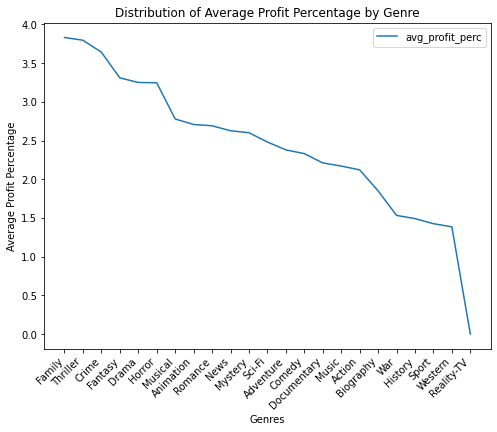

In [43]:
# Create figure
fig, ax = plt.subplots(figsize = (8,6))

# Create the line plot
sns.lineplot(data=genre_by_profit)

# Set the x-axis tick positions and labels
plt.xticks(range(len(genre_by_profit.index)), genre_by_profit.index, rotation=45, ha='right')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Profit Percentage')
plt.title('Distribution of Average Profit Percentage by Genre')


# Show the plot
plt.show()

Top genres are Family, Thriller and Crime based on average profit by genre.



## Most Popular Director For the Family Genre

In [20]:
pop_directors = pd.read_sql("""
SELECT  p.primary_name AS director,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM directors AS d 
JOIN persons AS p
    ON d.person_id = p.person_id
JOIN movie_basics as m
    ON m.movie_id = d.movie_id
JOIN tn_movie_budgets AS t
    ON t.movie = m.primary_title
WHERE genres LIKE '%Family%'
GROUP BY director
ORDER BY average_profit_perc DESC
LIMIT 10
""", conn)
pop_directors

,director,average_profit_perc
0,Karthik Chandan,124.277880
1,Brandon Camp,63.119120
2,Jesse Rose,19.534452
3,Adam Sputh,19.534452
4,Stephen Chbosky,15.230236
5,Nelson Venkatesan,12.848163
6,Jon Erwin,12.229174
7,Andrew Erwin,12.229174
8,Ravi Punj,11.041042
9,Michael Scordakis,10.884333


## Most Popular Writer For the Family Genre

In [21]:
pop_writers = pd.read_sql("""
SELECT  p.primary_name AS writer,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM writers AS w
JOIN persons AS p
    ON w.person_id = p.person_id
JOIN movie_basics as m
    ON m.movie_id = w.movie_id
JOIN tn_movie_budgets AS t
    ON t.movie = m.primary_title
WHERE genres LIKE '%Family%'
GROUP BY writer
ORDER BY average_profit_perc DESC
LIMIT 10
""", conn)
pop_writers

,writer,average_profit_perc
0,Joe Camp,63.119120
1,Brandon Camp,63.119120
2,Steve Conrad,15.230236
3,R.J. Palacio,15.230236
4,Jack Thorne,15.230236
5,Sankar Dass,12.848163
6,Nelson Venkatesan,12.848163
7,Jon Erwin,12.229174
8,Brent McCorkle,12.229174
9,Bart Millard,12.229174


## Visualize popularity of Directors and Writers

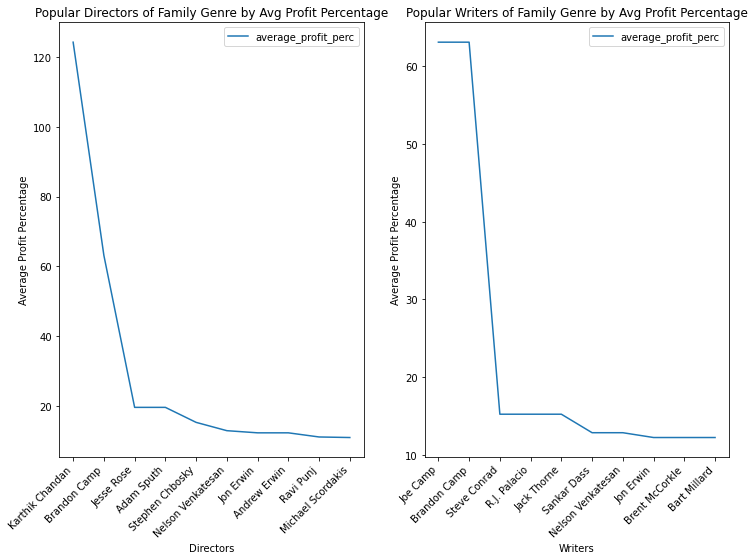

In [22]:
# Create figure and axes
fig, ax = plt.subplots(ncols=2, figsize=(12, 8))

# Plot for directors
sns.lineplot(data=pop_directors, ax=ax[0])
ax[0].set_xticks(range(len(pop_directors['director'])))
ax[0].set_xticklabels(pop_directors['director'], rotation=45, ha='right')
ax[0].set_xlabel('Directors')
ax[0].set_ylabel('Average Profit Percentage')
ax[0].set_title('Popular Directors of Family Genre by Avg Profit Percentage')

# Plot for writers
sns.lineplot(data=pop_writers, ax=ax[1])
ax[1].set_xticks(range(len(pop_writers['writer'])))
ax[1].set_xticklabels(pop_writers['writer'], rotation=45, ha='right')
ax[1].set_xlabel('Writers')
ax[1].set_ylabel('Average Profit Percentage')
ax[1].set_title('Popular Writers of Family Genre by Avg Profit Percentage')

# Show the plot
plt.show()

In [ ]:
pd.read_sql("""

SELECT *
FROM movie_basics
LIMIT 5

""", conn)

# i want a row in the database for each genre per movie, so multiple rows for each movie

In [30]:
# get top directors
directors = pd.read_sql("""

WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
)
SELECT DISTINCT 
                p.primary_name AS director,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM split
JOIN movie_basics AS m
    ON instr(genres, genre) > 0
    
JOIN directors AS d
    ON m.movie_id = d.movie_id
JOIN persons AS p
    ON d.person_id = p.person_id
JOIN tn_movie_budgets AS t
    ON t.movie = m.primary_title
    
WHERE genre!='' AND genre = "Family"
GROUP BY director
ORDER BY average_profit_perc DESC
LIMIT 10    

""", conn)

In [45]:
directors

,director,average_profit_perc
0,Karthik Chandan,124.277880
1,Brandon Camp,63.119120
2,Jesse Rose,19.534452
3,Adam Sputh,19.534452
4,Stephen Chbosky,15.230236
5,Nelson Venkatesan,12.848163
6,Jon Erwin,12.229174
7,Andrew Erwin,12.229174
8,Ravi Punj,11.041042
9,Michael Scordakis,10.884333


In [28]:
# get top writers
writers = pd.read_sql("""

WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
)

SELECT DISTINCT 
                p.primary_name AS writer,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM split
JOIN movie_basics AS m
    ON instr(genres, genre) > 0
    
JOIN writers AS w
    ON m.movie_id = w.movie_id
JOIN persons AS p
    ON w.person_id = p.person_id
JOIN tn_movie_budgets AS t
    ON t.movie = m.primary_title
    
WHERE genre!='' AND genre = "Family"
GROUP BY writer
ORDER BY average_profit_perc DESC
LIMIT 10
""", conn)

In [46]:
writers

,writer,average_profit_perc
0,Joe Camp,63.119120
1,Brandon Camp,63.119120
2,Steve Conrad,15.230236
3,R.J. Palacio,15.230236
4,Jack Thorne,15.230236
5,Sankar Dass,12.848163
6,Nelson Venkatesan,12.848163
7,Jon Erwin,12.229174
8,Brent McCorkle,12.229174
9,Bart Millard,12.229174


In [84]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

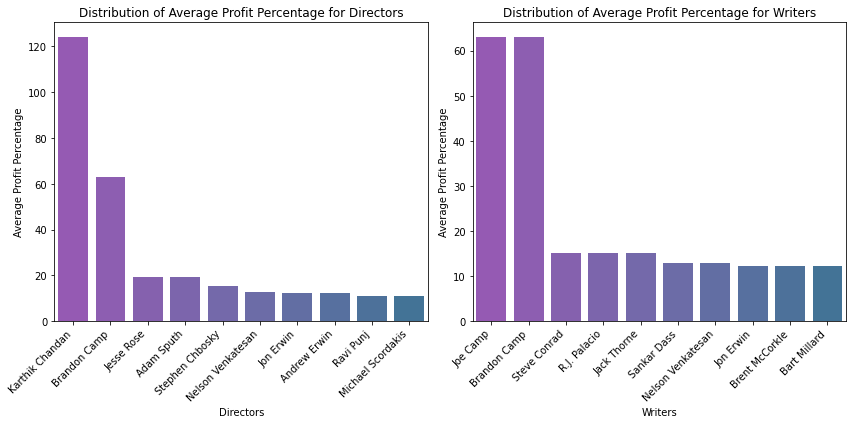

In [98]:
# Create figure and axes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

color1 = "#9A4BC2"
color2 = "#3575A4"
color_gradient = get_color_gradient(color1, color2, len(writers))

# Histogram for directors
sns.barplot(data=directors, x='director', y='average_profit_perc', palette=color_gradient, ax=ax1)
ax1.set_xticklabels(directors['director'], rotation=45, ha='right')
ax1.set_xlabel('Directors')
ax1.set_ylabel('Average Profit Percentage')
ax1.set_title('Distribution of Average Profit Percentage for Directors')

# Histogram for writers
sns.barplot(data=writers, x='writer', y='average_profit_perc', palette=color_gradient, ax=ax2)
ax2.set_xticklabels(writers['writer'], rotation=45, ha='right')
ax2.set_xlabel('Writers')
ax2.set_ylabel('Average Profit Percentage')
ax2.set_title('Distribution of Average Profit Percentage for Writers')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [115]:
# get top actors
actors = pd.read_sql("""

SELECT p.primary_name AS actor,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / 
                                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM persons AS p
    JOIN known_for AS k
        ON p.person_id = k.person_id
    JOIN movie_basics AS m
        ON k.movie_id = m.movie_id
    JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
WHERE primary_profession LIKE '%actor%' AND
                genres LIKE '%Family%'
GROUP BY actor
ORDER BY average_profit_perc DESC
LIMIT 10

""", conn)

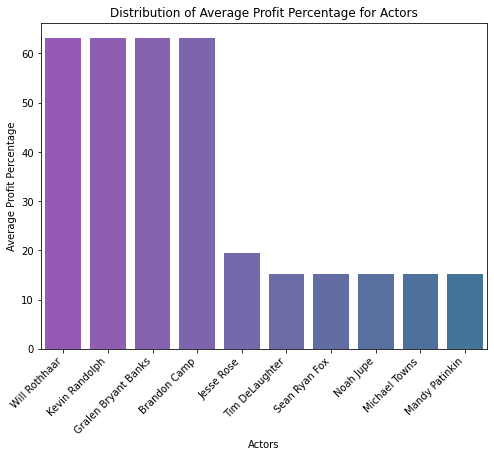

In [121]:
fig, (ax1) = plt.subplots( figsize=(8, 6))

sns.barplot(data=actors, x='actor', y='average_profit_perc', palette=color_gradient, ax=ax1)
ax1.set_xticklabels(actors['actor'], rotation=45, ha='right')
ax1.set_xlabel('Actors')
ax1.set_ylabel('Average Profit Percentage')
ax1.set_title('Distribution of Average Profit Percentage for Actors');

In [122]:
conn.close()